In [306]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes

# Generate Dataframe
df = pd.read_csv("uber-fares-dataset/uber.csv")

## Cleaning the Data

Before we start formally cleaning the data, we made sure to take a look at the data we are working with as well as their data types and potential missing values.

Right off the bat, we noted that some latitude and longitude values do not fall within the actual latitude and longitude ranges.
For example, latitude values range between -90 and 90 whereas longitude values range between -180 and 180. Values like -3356.66630 for the longitude will skew the data, so we will need to handle their observational units accordingly.

In [307]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [308]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


From the .info() function we found that the longitude and latitude values contain a null value. We will need to address that later during our data cleanup.

In [309]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


We decided to plot fare_amount vs passenger count to see if we could find any correlations for data evaluation, and we found that the passenger count contains an outlier, which we will also need to address during the data cleanup.

<AxesSubplot:xlabel='fare_amount', ylabel='passenger_count'>

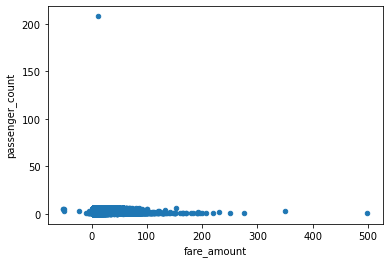

In [310]:
df.plot(kind="scatter", x="fare_amount", y="passenger_count")

To combat the rather strange values in the latitude and longitude columns, we will need to remove any observational units that do not fall within the specified latitude and longitude range. 

Before doing so, we will first need to drop any null values from our dataset.

In [311]:
df = df.dropna()

In [312]:
# Drop Pickup Latitude & Longitude Values Outside of Range
df.drop(df.loc[df['pickup_latitude'] > 90].index, inplace=True)
df.drop(df.loc[df['pickup_latitude'] < -90].index, inplace=True)

df.drop(df.loc[df['pickup_longitude'] > 180].index, inplace=True)
df.drop(df.loc[df['pickup_longitude'] < -180].index, inplace=True)


/Users/sofiamurillosanchez/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [313]:
# Drop Dropoff Latitude & Longitude Values Outside of Range
df.drop(df.loc[df['dropoff_latitude'] > 90].index, inplace=True)
df.drop(df.loc[df['dropoff_latitude'] < -90].index, inplace=True)

df.drop(df.loc[df['dropoff_longitude'] > 180].index, inplace=True)
df.drop(df.loc[df['dropoff_longitude'] < -180].index, inplace=True)


In [314]:
# Drop the outlier in the passenger_count
df.drop(df.loc[df['passenger_count'] > 200].index, inplace=True)
df.drop(df.loc[df['passenger_count'] <= 0].index, inplace=True)

From taking a look at .info() and .describe, we can see that there are no longer any null values and all the latitude and longitude values fall within normal ranges. Now we can start with our preprocessing.

In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199278 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         199278 non-null  int64  
 1   key                199278 non-null  object 
 2   fare_amount        199278 non-null  float64
 3   pickup_datetime    199278 non-null  object 
 4   pickup_longitude   199278 non-null  float64
 5   pickup_latitude    199278 non-null  float64
 6   dropoff_longitude  199278 non-null  float64
 7   dropoff_latitude   199278 non-null  float64
 8   passenger_count    199278 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 15.2+ MB


In [316]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.992780e+05,199278.000000,199278.000000,199278.000000,199278.000000,199278.000000,199278.000000
mean,2.771619e+07,11.366671,-72.503962,39.919060,-72.513455,39.922963,1.689494
std,1.601399e+07,9.910696,10.442940,6.128077,10.406284,6.115936,1.305419
min,1.000000e+00,-52.000000,-93.824668,-74.015515,-75.458979,-74.015750,1.000000
25%,1.382710e+07,6.000000,-73.992063,40.734795,-73.991409,40.733826,1.000000
50%,2.775604e+07,8.500000,-73.981825,40.752584,-73.980094,40.753041,1.000000
75%,4.156007e+07,12.500000,-73.967158,40.767155,-73.963663,40.767995,2.000000
max,5.542357e+07,499.000000,40.808425,48.018760,40.831932,45.031598,6.000000


## Scaling, Normalizing, and Standardizing Features using sklearn.preprocessing

Before we jump into anything else, we decided on preprocessing the data in order to standardize the dataset. This will make the rest of the process run smoother because the data will "change raw feature vectors into a representation that is more suitable for the downstream estimators." (Source: https://scikit-learn.org/stable/modules/preprocessing.html)

Before running the scaler on the data, we will need to drop any categorical variables/any variables that are not in a number format because the scaler only works with number data.

In [317]:
# Drop the key and pickup_datetime and save those variables in a different dataframe (to be used later)
df_scale = df.drop({"key", "pickup_datetime"}, axis = 1)
df_labels = df[{"key", "pickup_datetime"}]

Then, we will run the StandardScaler on the dataframe and check the mean and scale.

In [318]:
scaler = preprocessing.StandardScaler().fit(df_scale)

In [319]:
scaler.mean_

array([ 2.77161872e+07,  1.13666709e+01, -7.25039619e+01,  3.99190596e+01,
       -7.25134546e+01,  3.99229626e+01,  1.68949407e+00])

In [320]:
scaler.scale_

array([1.60139529e+07, 9.91067136e+00, 1.04429138e+01, 6.12806151e+00,
       1.04062574e+01, 6.11592109e+00, 1.30541601e+00])

Next, we will transform the scaler and store it in a new dataframe and also check the mean and standard deviation.

In [321]:
df_scaled = scaler.transform(df_scale)
df_scaled.mean(axis=0)

array([ 1.12315941e-16,  2.17643335e-16,  1.16667738e-15, -7.77119347e-16,
       -9.14840085e-16,  1.36633234e-15, -5.54805095e-17])

In [322]:
df_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1.])

After scaling the data, we created a correlation matrix to see how the rest of the data relates to the fare amount. From looking at the correlation matrix, we found that none of the columns have a strong correlation to the fare amount.

In [323]:
corr_matrix = df_scale.corr()

In [324]:
corr_matrix["fare_amount"].sort_values(ascending=False)

fare_amount          1.000000
dropoff_longitude    0.011698
pickup_longitude     0.011586
passenger_count      0.009905
Unnamed: 0           0.000587
pickup_latitude     -0.011512
dropoff_latitude    -0.012094
Name: fare_amount, dtype: float64

## Use sklearn.tree.DecisionTreeRegressor & Use k-fold Cross Validation (cross_val_score)

In [325]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(df_scaled, )

# X, y = load_diabetes(return_X_y=True)
# regressor = DecisionTreeRegressor(random_state=0)

# Cross Validation Score
# cross_val_score(regressor, X, y, cv=10)

TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
# Referenced from O'Reilley Hands On Machine Learning Textbook

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(df, 0.2)

In [ ]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32


In [ ]:
pipe = make_pipeline(StandardScaler(), DecisionTreeRegressor())
pipe.fit(X, y)
pipe.score(X, y)

1.0